In [1]:
# from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
file_path = "..\\..\\Datasets\\BigData.xlsx"
data_title = "data_test_raw_data"

columns_data = ['1' ,'2', '3', '4', '5', '6', '7', '8', 'N/A_1', 'N/A_2', 'angle', 'time', 'session']
columns_features_considered = columns_data[:8]
column_ground_truth = columns_data[10]
# Note that we ignore the 'time' column. That makes our data slightly imprecise as there are tiny, 
# TINY differences in time intervals in the real data (not worth modeling). Each timestep represents 
# 1 millisecond, 0.001 second. 

In [3]:
# Read first sheet (table of contents), find index of entry with correct title, then load the corresponding excel sheet
table_of_contents = pd.read_excel(file_path, sheet_name=0, header=None)
sheet_index = table_of_contents[table_of_contents[0] == data_title][0].index[0]
sheet_data = pd.read_excel(file_path, sheet_name=sheet_index + 1, header=None)
sheet_data.columns = columns_data

In [69]:
GRANULARITY = 10 # Take first item, skip 3, take next, skip 3, take next, ...

indexes = range(0, len(sheet_data), 1)[::GRANULARITY] # Each timestep is a millisecond
features = sheet_data[columns_features_considered][::GRANULARITY]
ground_truth = pd.DataFrame(sheet_data[column_ground_truth][::GRANULARITY])

#data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
#data_std = dataset[:TRAIN_SPLIT].std(axis=0)
#dataset = (dataset-data_mean)/data_std
# SEEMS UNECESSARY, AS WE NORMALIZE ON THE SENSOR
# HOW MUCH DIFFERENCE IS THERE?

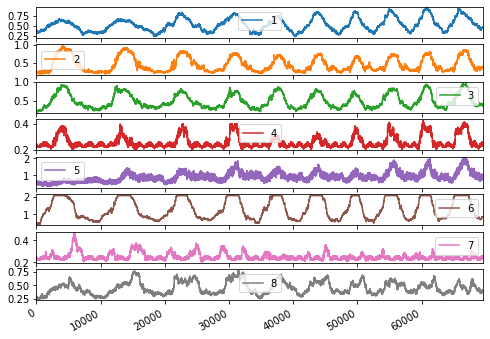

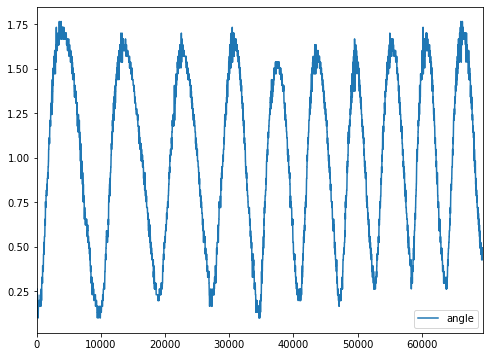

In [70]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
features.plot(subplots=True)

ground_truth.plot()

In [71]:
def multivariate_data(dataset_features, dataset_ground_truth, start_index, end_index, history_size,
                      target_size, step, granularity, single_step=False, print_index=False):
  data, labels, history = [], [], []

  start_index = start_index + history_size 
  # such that we always have history_size (100) observations to base our predictions on
  if end_index is None:
    end_index = len(dataset) - target_size 
    # such that we never predict based on the last future_target (10) measurements

  if print_index: print("start")
  for i in range(start_index, end_index): # start 100, end 790. 
      # TODO: It actually goes to 800 (when end_index is not None), meaning that our last 10 predictions cannot be verified with our training set. This is a problem
    if print_index: print("A", i,)
    # indices = range(i-history_size, i, granularity) # --- our sliding window
    indices = range(i-history_size, i, step) # range(0, 100) step size of 1          --- our sliding window
    data.append(dataset_features[indices]) # append new array that contains all values within our sliding window
    # TODO: ONE PROBLEM KINDA? Step size makes no sense. Doesn't feel like there's any point to it. 
    
    # NOTE: RIGHT NOW PAST_HISTORY DENOTES THE AMOUNT!!! OF PREVIOUS MEASUREMENTS TO USE, NOTHING TO DO WITH THEIR TIME
    
    history.append(dataset_ground_truth[indices])

    if single_step:
      labels.append(dataset_ground_truth[i+target_size])
    else:
      labels.append(dataset_ground_truth[i:i+target_size])

  return np.array(data), np.array(labels), np.array(history)

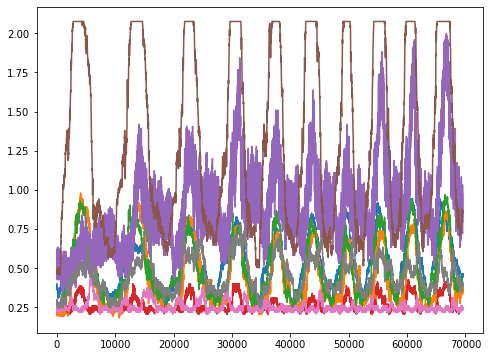

In [76]:
STEP_SIZE_SLIDING_WINDOW = 5
# TODO: Granularity actually messes up my window step size, because one affects my dataset in 
# total (and I don't use time as index). 

dataset = features.values

past_history = 20
future_target = 1
# Aggregates STEP predictions, looks at a total of PASTHISTORY observations, 
# predicts the observation at FUTURETARGET observations in the future
TRAIN_PERCENT = 0.1
TRAIN_SPLIT = int(len(dataset) * (1 - TRAIN_PERCENT))

# TODO -------------------------------------
VAL_PERCENT = 0.1
VAL_SPLIT = int(len(dataset) * (1 - VAL_PERCENT))
# TODO: Split into test set here!

plt.plot(indexes, dataset)

#print(dataset.shape, ground_truth.shape)
#print(dataset[0], dataset[1], dataset[2], dataset[3], dataset[4], dataset[5], dataset[6], dataset[7])

In [79]:
for x in range(0, 10, 50):
    print(x, end=" ") 
x_train, y_train, _ = multivariate_data(dataset, ground_truth.values, 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP_SIZE_SLIDING_WINDOW, GRANULARITY,
                                                   single_step = False, print_index = False)

print ('Single window of past history : {}'.format(x_train[0].shape))
print(len(x_train), len(y_train))
print(x_train.shape)

0 Single window of past history : (4, 8)
6238 6238
(6238, 4, 8)


In [80]:
x_val, y_val, y_history = multivariate_data(dataset, ground_truth.values, TRAIN_SPLIT, 
                                               None, past_history,
                                               future_target, STEP_SIZE_SLIDING_WINDOW, GRANULARITY,
                                               single_step=False, print_index = False)

In [81]:
EPOCHS = 5
#BATCH_SIZE = 1
#BUFFER_SIZE = 100
#BATCH_SIZE_TRAIN = len(x_train)
#BATCH_SIZE_VAL = len(x_val)
BATCH_SIZE_TRAIN = 1
BATCH_SIZE_VAL = 1
# BATCH_SIZE SEEMS TO BE THE WRONG NAME, RATHER IT'S BATCH_AMOUNT. Check if this is the case before changing.

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE_TRAIN).repeat(EPOCHS)
val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE_VAL).repeat(EPOCHS)
val_data_once = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE_VAL)
#val_data_history = tf.data.Dataset.from_tensor_slices((x_val, y_val, y_history)).batch(BATCH_SIZE_VAL)

#train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
#val_data = val_data.batch(BATCH_SIZE).repeat()

In [83]:
model = tf.keras.models.Sequential()
#model.add(tf.keras.layers.LSTM(32, batch_input_shape=(BATCH_SIZE, x_train.shape[1], x_train.shape[2]), return_sequences = False)) # input_shape=x_train.shape[-2:]
model.add(tf.keras.layers.LSTM(32, input_shape=x_train.shape[-2:], return_sequences = False))
model.add(tf.keras.layers.Dense(future_target))

#model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae',metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5248      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 5,281
Trainable params: 5,281
Non-trainable params: 0
_________________________________________________________________


In [84]:
EVALUATION_INTERVAL = len(x_train) // BATCH_SIZE_TRAIN 
# After how many observations it stops and re-evaluates / re-calculates its ((batch weights, arguments, whatevs))??? 
# with gradient descent
VAL_STEPS = len(y_val) // BATCH_SIZE_VAL

history = model.fit(train_data, epochs=EPOCHS,
                    steps_per_epoch=EVALUATION_INTERVAL,
                    validation_data=val_data,
                    validation_steps=VAL_STEPS
                    )

Train for 6238 steps, validate for 675 steps
Epoch 1/5
6238/6238 [==============================] - 56s 9ms/step - loss: 0.0256 - categorical_accuracy: 1.0000 - val_loss: 0.2786 - val_categorical_accuracy: 1.0000
Epoch 2/5
6238/6238 [==============================] - 43s 7ms/step - loss: 0.0238 - categorical_accuracy: 1.0000 - val_loss: 0.2824 - val_categorical_accuracy: 1.0000
Epoch 3/5
6238/6238 [==============================] - 41s 7ms/step - loss: 0.0230 - categorical_accuracy: 1.0000 - val_loss: 0.2716 - val_categorical_accuracy: 1.0000
Epoch 4/5
6238/6238 [==============================] - 41s 7ms/step - loss: 0.0232 - categorical_accuracy: 1.0000 - val_loss: 0.2528 - val_categorical_accuracy: 1.0000
Epoch 5/5
6238/6238 [==============================] - 41s 7ms/step - loss: 0.0228 - categorical_accuracy: 1.0000 - val_loss: 0.2451 - val_categorical_accuracy: 1.0000


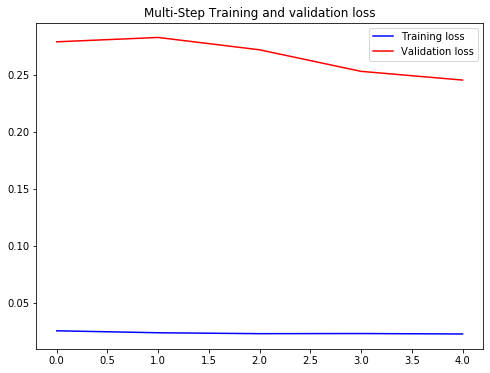

In [85]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

plot_train_history(history, 'Multi-Step Training and validation loss')

675
675
675
6954
6954


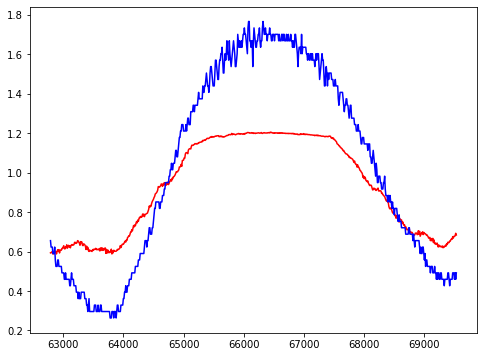

In [91]:
predictions = [model.predict(elem)[0] for elem in val_data_once]
pred_size = len(indexes)-len(predictions)
plt.plot(indexes[pred_size:], predictions, 'r')
plt.plot(indexes[pred_size:], ground_truth[pred_size:], 'b')


#def create_time_steps(length):
#  time_steps = []
#  for i in range(-length, 0, 1):
#    time_steps.append(i)
#  return time_steps

#def multi_step_plot(history, true_future, prediction):
#  plt.figure(figsize=(12, 6))
#  num_in = create_time_steps(len(history))
#  num_out = len(true_future)

#  plt.plot(num_in, np.array(history[:, 0]), label='History')
#  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
#           label='True Future')
#  if prediction.any():
#    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
#             label='Predicted Future')
#  plt.legend(loc='upper left')
#  plt.show()

# TODO: This ought to be test_data
#for x, y in val_data.take(3):
#  multi_step_plot(x[0], y[0], model.predict(x)[0])

# print(val_data[50])

# print(len(val_data))

#iterator = iter(val_data)
#elem = next(iterator)
#print(elem[1])

#print(val_data)
#print(val_data_history)

# History should be the old angle measurements (that aren't used for training)
#for num in [1, 100, 200, 300, 400, 500]:
#    for index, elem in enumerate(val_data_history):
#        if index == num:
#            # print(index, elem[2][0]) # print index and y value
#            print(index, model.predict(elem[0])[0])
#            multi_step_plot(elem[2][0], elem[1][0], model.predict(elem[0])[0])
#            break

# TODO: Show entire history in one plot, then show some instances of sliding window predictions on that plot
# instead of only being able to show the sliding windows as separate plots 
# Probably add time index to accomplish this <--

# Todo: perhaps add a time dimension back as index. Because otherwise if you use STEP-size, then it won't know that it
# skipped some time (20 measurements means 20 timesteps, instead of the 100 truncated time steps)

# Todo: use separate test-data instead of using validation data for testing

